# Misturando ViT_Gráficos_3 com vit_keras.vit_b16 

In [1]:
!pip install -U tensorflow-addons
!pip install vit_keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 1
n_classes = 7
num_epochs = 30
image_size = 224  # We'll resize input images to this size

In [4]:
from pathlib import Path
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'
    
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(image_size, image_size),
                      class_mode='categorical',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

valid_generator = datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(image_size, image_size),
                      class_mode='categorical',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [5]:
x_train = []
y_train = []
x_train,y_train = next(train_generator)
x_test = []
y_test = []
x_test,y_test = next(valid_generator)

for i in range(len(train_generator)-1):
    x_train = np.append(x_train, train_generator[i+1][0], axis=0)
    y_train = np.append(y_train, train_generator[i+1][1], axis=0)
for i in range(len(valid_generator)-1):
    x_test = np.append(x_test, valid_generator[i+1][0], axis=0)
    y_test = np.append(y_test, valid_generator[i+1][1], axis=0)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [7]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = n_classes)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
from tensorflow.keras import layers, models

def create_vit_classifier():

  flatten_layer = layers.Flatten()
  dense_layer_1 = layers.Dense(4096, activation='relu')
  dense_layer_2 = layers.Dense(1072, activation='relu')
  dropout = layers.Dropout(0.2)
  prediction_layer = layers.Dense(n_classes, activation='softmax')


  model = models.Sequential([
      data_augmentation,
      vit_model,
      flatten_layer,
      dropout,
      dense_layer_1,
      dropout,
      dense_layer_2,
      prediction_layer
  ])

  optimizer = tfa.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.BinaryAccuracy(name="accuracy"),
          # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
      ],
  )

  return model

In [9]:
def run_experiment(model):
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_generator,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=valid_generator,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)  


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


280/280 [==============================] - 101s 269ms/step - loss: 0.4882 - accuracy: 0.8332 - val_loss: 0.4114 - val_accuracy: 0.8531
Epoch 2/30
280/280 [==============================] - 73s 259ms/step - loss: 0.4229 - accuracy: 0.8515 - val_loss: 0.3579 - val_accuracy: 0.8653
Epoch 3/30
280/280 [==============================] - 65s 231ms/step - loss: 0.4345 - accuracy: 0.8444 - val_loss: 0.4655 - val_accuracy: 0.8571
Epoch 4/30
280/280 [==============================] - 71s 252ms/step - loss: 0.4123 - accuracy: 0.8505 - val_loss: 0.3353 - val_accuracy: 0.8694
Epoch 5/30
280/280 [==============================] - 66s 236ms/step - loss: 0.3496 - accuracy: 0.8556 - val_loss: 0.3449 - val_accuracy: 0.8490
Epoch 6/30
280/280 [==============================] - 66s 234ms/step - loss: 0.3515 - accuracy: 0.8480 - val_loss: 0.3262 - val_accuracy: 0.8653
Epoch 7/30
280/280 [==============================] - 64s 229ms/step - loss: 0.3289 - accuracy: 0.8541 - val_loss: 0.3093 - val_accuracy: 0.

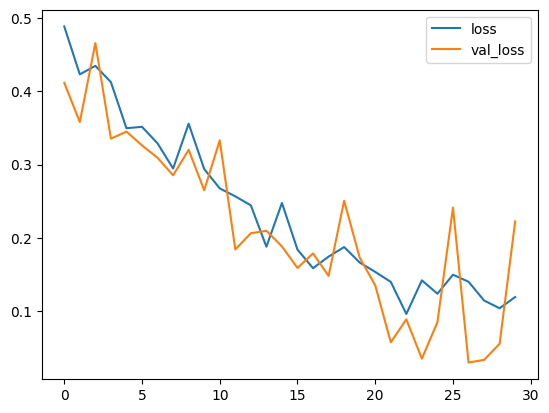

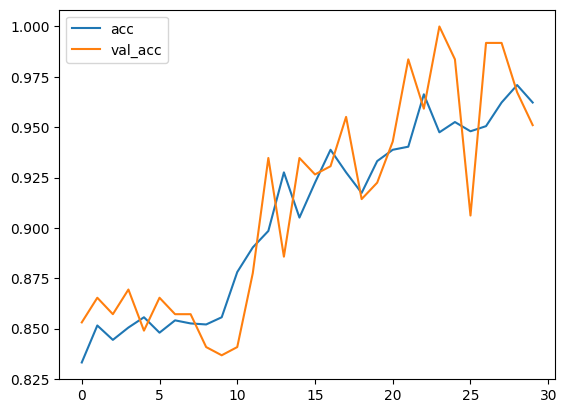

In [10]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [11]:
probs = vit_classifier.predict(x_test)

2/2 [==============================] - 4s 103ms/step


Precisão: 1.0


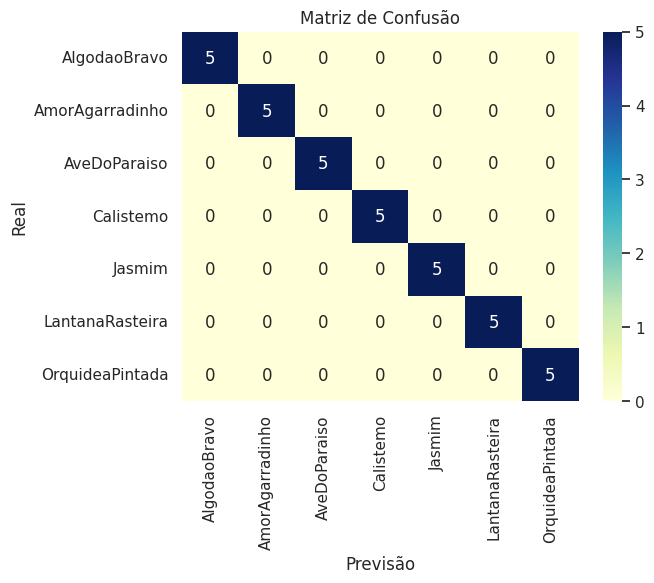

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = np.argmax(y_test, axis=1)

# Obter os nomes das classes
class_names = list(valid_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

     


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Exibir o relatório de classificação
print(report)

     


                 precision    recall  f1-score   support

   AlgodaoBravo       1.00      1.00      1.00         5
AmorAgarradinho       1.00      1.00      1.00         5
   AveDoParaiso       1.00      1.00      1.00         5
      Calistemo       1.00      1.00      1.00         5
         Jasmim       1.00      1.00      1.00         5
LantanaRasteira       1.00      1.00      1.00         5
OrquideaPintada       1.00      1.00      1.00         5

       accuracy                           1.00        35
      macro avg       1.00      1.00      1.00        35
   weighted avg       1.00      1.00      1.00        35

